# Instagram Brand Alignment analysis 



In [95]:

import gc
gc.collect()
import pandas as pd
import numpy as np
# import spacy
from scipy.stats import zscore
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity 
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob 
import re
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util
from sentence_transformers.util import cos_sim

import torch
import webbrowser
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import gensim
from gensim.models import LdaModel  
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel 

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

from keybert import KeyBERT
kw_model = KeyBERT(model='all-MiniLM-L6-v2')  

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/floodywaves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [140]:


insta_path ='../output/instagram'
insta_csv = glob.glob(os.path.join(insta_path, '*.csv'))
brand_value = pd.read_csv("../output/Brands  - Sheet1.csv")
brand_map_to_files = {
    'esteelauder.csv': 'Estée Lauder',
    'corsx.csv': 'COSRX',
    'etude.csv': 'Etude House',
    'fentybeauty.csv': 'Fenty Beauty',
    'glossier.csv': 'Glossier',
    'innisfree.csv': 'Innisfree',
    'laneige.csv': 'Laneige',
    'sulwhasoo.csv': 'Sulwhasoo',
    'tarte.csv': 'Tarte Cosmetics',
    'elf_cosmetics.csv': 'e.l.f. Cosmetics'
}
data_frames = []
for file in insta_csv:
    df = pd.read_csv(file, low_memory=False)

    filename = os.path.basename(file)
    # Add brand column using the mapping
    df['brand'] = brand_map_to_files[filename]
    data_frames.append(df)

insta_df = pd.concat(data_frames)

insta_df.head()

,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,post_owner.type,post_owner.id,post_owner.name,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text,brand
0,videos,2025-05-28T21:57:20+00:00,"[""cosmabent"",""skincare"",""reels"",""koreanskincareproducts"",""explore"",""etudehouse"",""fyp"",""eyelash"",""eyelashserum""]",1.100108e+15,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/content-library/dataset/1119037145491882/instagram/post/1100107921939783/,2025-05-28T21:59:46+00:00,"[{""id"":""1100107921939783"",""type"":""video"",""duration"":18.08,""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZtKLGhWbeUmysvnKsnKPcY4Vo1cRjFNAXElUgSTqX4GixdLvsZo2RsXIiQdBeh3Qm2ZPh2dC9-4czRQzMxeoOwvpVHR_5TNUgd1yjM1nYvYszPF-mrIY46tpTD02cHIR8jSbPkErwPtThsQScp5""}]",creator,1260634928919791,𝑪𝑶𝑺𝑴𝑨𝑩𝑬𝑵𝑻 𝓒𝓸𝓼𝓶𝓮𝓽𝓲𝓬𝓼,cosmabent,1.0,106.0,6533.0,2025-05-29,Eyelashes serum from etude house🇰🇷\n.\n.\n.\n.\n.\n#eyelash #eyelashserum #etudehouse #skincare #koreanskincareproducts #cosmabent #fyp #explore #reels #reels,Etude House
1,videos,2025-05-28T17:38:36+00:00,"[""behindthescenes"",""avantgarde"",""sophietaeuberarp"",""limitededition"",""fondationarp"",""artiststudio""]",9.935671e+14,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/content-library/dataset/1119037145491882/instagram/post/993567122949539/,2025-05-28T23:28:42+00:00,"[{""id"":""993567122949539"",""type"":""video"",""duration"":21.67,""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZuGDy07KEkAbEjA_dRmqFd8t2E9eoTI4t6qruKop6ghNPT5mdKF9_2c1nsBN6jz-5PuJbFycuaXW-C4VigE4-OfsmR9Yy5iVs1MoH1b4bd3pRFBb9RnHpU4QOTd9tJmPyY0a1NlbxAHPwhEW0s""}]",business,995199895325835,Christopher Farr,christopherfarrdesign,3.0,30.0,660.0,2025-05-29,"A day out in Paris, made extra special with a visit to our friends @fondationarp, the former home and studio of artist and polymath Sophie Taeuber-Arp and her husband Jean Arp. Now an artist fondation and official Musée de France, we were lucky to be hosted for a private tour of the house and sculpture garden.\n.\nLocated on the edge of the forest of Meudon, the studio-house, designed by the prolific Taueber-Arp was always a place for encounters and exchange of ideas with visiting art collectors and the couple’s friends, central to the #avantgarde scene, including Max Ernst, Nelly and Theo van Doesburg, Joan Miró, André Breton, Robert and Sonia Delaunay to name a few.\n.\nIt was a wonderful to see our rugs, produced from original artworks of #SophieTaeuberArp, set out in the artist’s home; ‘Etude Ligne’ hand knotted and made to order and CF Editions ‘Aubette Study’, ready for immediate purchase @tateshops.\n.\nThanks so much to Ètienne Robial, President of #FondationArp and Sébastien Tardy, Head of Collections. #behindthescenes #artiststudio #limitededition",Etude House
2,videos,2025-05-27T20:27:58+00:00,"[""asianbeauty"",""cbeauty"",""healthyskin"",""kskincare"",""koreanskincare"",""kbeautyroutine"",""kbeauty"",""skinproducts"",""beautyroutine"",""koreanskincareroutine"",""kbeautyskincare""]",6.559739e+14,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/content-library/dataset/1119037145491882/instagram/post/655973890778111/,2025-05-29T03:28:03+00:00,"[{""id"":""655973890778111"",""type"":""video"",""duration"":32.63,""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZttFiKu8V0TnVlstcT3pGuBo1I-Dm-2y-HAaNwSqtPV4Kk1eBraA7tSLYuqRCFUbNID0dogZK50-wB3wVfHenTKral55BEjt8jEkT7d_v3V8opAefnIwD6V_R2pSyP67qrfxbUVfX0vdN8S1f8""}]",business,1119286263225086,"Kiokii and | Asian Beauty, Skincare & Makeup 🇨🇦",kiokii.official,2.0,288.0,14276.0,2025-05-29,"🎨 Top 8 Makeup Must-Haves at Kiokii! 💖\nFrom juicy lips to fluttery lashes, here are our best-selling picks that beauty lovers can’t stop restocking:\n\n💋 Etud

In [141]:


tqdm.pandas()
brand_value.columns = brand_value.columns.str.strip().str.lower()
insta_df.columns = insta_df.columns.str.strip().str.lower()
insta_df = insta_df[insta_df['brand'].notna()]

custom_stopwords = [    "follow", "like", "likes", "just", "really", "thanks", "omg",
    "hi", "hey", "pls", "please", "gonna", "tbh", "honestly",
    "lol", "lmao", "idk", "link", "click", "watch", "dm", "recommend",]
stopword_set = set(nltk_stopwords.words('english')).union(custom_stopwords)
junk_words = {"breast", "trip", "solo", "hi", "wonder", "style", "shop", "list", "diy", "details", "ready"}

def clean_instagram_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+|#\w+|u/\w+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    tokens = word_tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stopword_set 
                      and t not in junk_words  # Add this
                      and len(t) > 2]
    return " ".join(filtered_tokens)



insta_df["cleaned_text"] = insta_df["text"].progress_apply(clean_instagram_text)
insta_df = insta_df[insta_df["cleaned_text"].str.split().str.len() > 3]

# Ignore word that are too common or too rare
tfidf = TfidfVectorizer(
    max_df=0.8, 
    min_df=2,
    max_features=10000,
    stop_words=list(stopword_set)
)
X = tfidf.fit_transform(insta_df["cleaned_text"])
important_words = set(tfidf.get_feature_names_out())

insta_df["cleaned_text"] = insta_df["cleaned_text"].progress_apply(
    lambda doc: " ".join([w for w in doc.split() if w in important_words])
)

# insta_df.head()


  1%|          | 2401/216850 [00:00<00:39, 5420.75it/s]

100%|██████████| 197099/197099 [00:01<00:00, 163269.41it/s]


In [142]:


brand_value = brand_value.rename(columns={"brand": "brand", "values/ mission": "brand_mission"})


merged_df = insta_df.merge(
    brand_value[["brand", "brand_mission"]],
    left_on="brand",
    right_on="brand",
    how="inner"
)
merged_df["brand"].unique()



# merged_df.head()




array(['Etude House', 'Estée Lauder', 'COSRX', 'Laneige',
       'Tarte Cosmetics', 'Innisfree', 'e.l.f. Cosmetics', 'Glossier',
       'Fenty Beauty', 'Sulwhasoo'], dtype=object)

In [207]:
# Compute alignment score
tqdm.pandas()
model = SentenceTransformer('all-MiniLM-L6-v2')

sample_df = merged_df.sample(2000, random_state=42)

# Encode the instagram comments as a vector 
# Meaning instrament comment matrix
text_embeds = model.encode(
    sample_df["text"].tolist(), 
    convert_to_tensor=True, 
    batch_size=64,     
    show_progress_bar=True
) 

brand_names = brand_value["brand"].tolist()
brand_missions = brand_value["brand_mission"].tolist()

# Encode all brand mission statements at once
# Should out 10 vectors for each brand mission statement
brand_mission_embeds = model.encode(
    brand_missions,
    convert_to_tensor=True,
    batch_size=10,  
    show_progress_bar=False
)
# Create a dictionary to map brand names to their indices offor quick lookup on brand_mission_embeds
brand_index = {brand: i for i, brand in enumerate(brand_names)}
# Map to the numeric index
brand_indices_tensor = torch.tensor(
    sample_df["brand"].map(brand_index).tolist(), 
    device=text_embeds.device 
)

selected_brand_embeds = brand_mission_embeds[brand_indices_tensor] # grab the correct brand mission statement

# Vectorized cosine similarity between matching brand mission and instagram comments
alignment = cos_sim(text_embeds, selected_brand_embeds).diagonal()

sample_df["alignment_score"] = alignment.cpu().numpy().tolist()


Batches: 100%|██████████| 32/32 [00:13<00:00,  2.41it/s]


,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,...,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text,brand,cleaned_text,brand_mission,alignment_score,z_score
75180,albums,2021-05-01T18:58:05+00:00,"[""laneigepakistan"",""cosmeticsbymaryam"",""originalskincarepakistan"",""laneigelipmask"",""laneige"",""laneigelipsleepingmask""]",1.227562e+15,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/content-library/dataset/1119037145491882/instagram/post/1227561618970237/,2024-04-25T23:55:45+00:00,"[{""id"":""1351961272588300"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZtGja9Jr03CDR1ewKfF1GkCvzz84eFwuyD78foXgy8mN-C7l4E8kR4iaH4DupS5E-HMA2nLOG1DQS0KuPSQasbSb9qrBPLUu7t6PCk-re9nogi4TzveLlBWTo1z6DcXek3_TUQUHhYy02ZkISMb""},{""id"":""709781861607352"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZvuJ49B86V9UyfYmJ4o2EYzxE6tXo0T5IHSbplz7xVe-RK2t1o3MWTchV7kBRRmcoq-5lRrxYx9UWOAMx85vCL3kC6QFdKv2s0VEFdYUfvCwwiBVlHdSX9WoLyjzgUh6dehjCIVVhY9T8CFr2k""},{""id"":""1064559795561366"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZtGo7ngLvXyGiKLMtgJfMr4_S57LbLSCuQKk-h4h_VuSby79ub-VZZkVT-Ad8FUaMGRHLIAmpJrYR1ZFIkXNgMJZNf2MCZ_ED_2U1CFbmfHBEkwUJDZ1Rlbx-MmNyOdJ5dKpE-xTF57XwlpzFPP""},{""id"":""1720450845572402"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZtQBpp4gThVQeKHevmfYASzyvD8lD9NGE98Wl9p-gmP5NCEKgA8vbHj6wrELcU1Pqfvnco6SCcV8fGc9JSS3GbjL1IzRvjrpuA6zVkEhYyJCN9FD-sZTmWfMbyXtdVBsN__Rmm9NGfB226VWziT""},{""id"":""2267440770379320"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZsI4_MXiMU_9ACv_jZnYqD1Xls7JzCAD2mWBogHHbEklZw5F2C4VsLWVoIJaHqi3zEPSD3OYOZFKohat-A_VEEoYp7E98J6jPp55ohtbJlh2PmrueTd9IA-jH_FmtzsdVFFER8LZZhteGh9GNBp""},{""id"":""1486765009411777"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZvOTgkC2278BLf4-JzsB1F9X1OHLa1ftqoBveniHXc03ngqU9vNhtimxKwNl0D1r9FWHCKP0mkCgVSIG2TKyk3qo8AidSyJZgpwIsjzi9hg6OX-RsZzBvU1zSejyKHEaN37O9ln908aJC8s7QfN""},{""id"":""1828571591270481"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZv4uzmw2Bubj5ieHAqhUVVlCAvgZuMpSKNQgvOzs5Hp7ijc6ko5Rj1EVXpBzlwVXkgVISlOcB6E26j6Jt17fiGai-phPBD73Dch9BL0x2d6fO_53qU1ww9McBbMMQMVpf_2XsaXFByEb9ILMZta""}]",...,13.0,86.0,NaN,NaN,"Price: Rs. 5,999/-\n.\nLaneige - Lip Sleeping Mask \n.\n.\n.\n.\n.\n#laneigepakistan #laneigelipmask #laneige #cosmeticsbymaryam #laneigelipsleepingmask #originalskincarepakistan",Laneige,price laneige lip sleeping mask,"We aim to create multi-tasking products that make caring for your skin easy. Our team is fascinated by how to better hydrate skin and lips, and are dedicated to continuing to research the latest and greatest ingredients while using our innovative technology to create formulas that deliver visible results—offering the dewy, bouncy skin you love.",0.290506,-0.824850
71393,videos,2022-03-18T12:02:41+00:00,"[""laneigebeautychatty"",""laneigemy""]",9.762730e+15,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/content-library/dataset/1119037145491882/instagram/post/9762729883781711/,2025-01-27T07:48:28+00:00,"[{""id"":""9762729883781711"",""type"":""video"",""duration"":9.63,""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZsZ8ktyMShUCEicLOiyX745E28uC-KL2zzLnsavrn1700DPABzVRwYBEpt1ZH5QwmtJm4o99aGweOOMpGJ63XITPU2pAVd_zVMLqZal9rVel95SwZQXQx_SOpHALZ2Xe-_W4K1Ik3jnZDSYH87s""}]",...,0.0,34.0,NaN,NaN,"Second chapter of Beauty Chatty, 𝗕𝗘𝗔𝗨𝗧𝗬 & 𝗟𝗜𝗙𝗘 𝗟𝗔𝗕!🧪\n\nDoes blue light really affect our skin?\n\nLet us dig into the questions about skin troubles caused by various lifestyles in the Laneige Beauty

In [214]:
sample_df[sample_df["brand"] == "COSRX"].sort_values("alignment_score", ascending=False)


,content_type,creation_time,hashtags,id,is_branded_content,lang,match_type,mcl_url,modified_time,multimedia,...,post_owner.username,statistics.comment_count,statistics.like_count,statistics.views,statistics.views_date_last_refreshed,text,brand,cleaned_text,brand_mission,alignment_score
54810,photos,2019-06-17T10:30:55+00:00,"[""linkinbio""]",5.840209e+14,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/content-library/dataset/1119037145491882/instagram/post/584020874728955/,2024-05-04T12:09:17+00:00,"[{""id"":""584020874728955"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZvWbDfZ39giVYgkHVqj_qf7ehzSAJp4N-2R_B3H_83r3aS2gijLns5q6cs5ifOsNNeRcxbiwEY1OXqUN8BKnJw9VlM3qsCXrjzOURRFHuKZTxzjVpY8fbcg3KqrV-TtyV2_jd7BWKNSMy-WJ4s""}]",...,hermomy,4.0,325.0,NaN,NaN,"Let's get real - getting on your ultimate skin care goals is hard work. LIFE ISN’T a bed of ROSES 🥀 , after all. .\n. \nBut fret not, Cosrx is here to amp up your skincare routine with more and better picks that'll help you to achieve your skin goals faster! .\n.\nShop Cosrx via #linkinbio",COSRX,let get real getting ultimate skin care goals hard work life bed roses fret cosrx amp skincare routine better picks help achieve skin goals faster cosrx via,"COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.743512
52210,photos,2020-09-11T04:00:51+00:00,"[""galengage5"",""skincare"",""clozette"",""snailsecretionfiltrate"",""skincareproducts"",""skincarecommunity"",""cosrxph"",""productshot"",""skincareph"",""skincaretips"",""skincareroutine"",""skingoals"",""skincareaddict""]",1.203413e+15,False,en,"[""post_text""]",https://www.facebook.com/transparency-tools/content-library/dataset/1119037145491882/instagram/post/1203413257650230/,2024-04-17T02:42:37+00:00,"[{""id"":""1203413257650230"",""type"":""photo"",""url"":""https://lookaside.facebook.com/mcl/multimedia/lookaside/?download_info=AZs0FrzWQNmKdOScXKc_EVHKYVXpSkAunL2LhThmlvDW1qmnMzhHkV6qZo1XHP3Glogke9MIsFFzufuAhVQkjt4vk_rdoUeW1KL0_aU6e6jHdXKCB7AxFJlFsVYbOiRAL3sIuILvkY_Urd2tqsXz""}]",...,danicadelossantos,53.0,312.0,NaN,NaN,"WHO IS COSRX? \n\nA world-renowned skincare brand from Korea that uses safe and natural ingredients to create gentle, effective solutions that your skin will love. A play on “cosmetics” and “Rx” (prescription), it gives you relevant and straightforward answers to addressing your skin imperfections, no matter your skin type.\n\nTheir pimple patch is my go-to product back in college. My overnight trusty patch that instantly helps me get rid of that stubborn pimple.\n\nThey have launched a new set of products with the main ingredient - Snail Secretion Filtrate. It is said to have alot of benefits; it nourishes and protects, fight against premature aging, fades acne scars, wrinkles, and stretch marks, Battles acne, dandruff, and many more! Wow! 🥰\n\nGet yours now, they are available at the @shopee_ph app! 🥰\n\n#clozette #skincare #skincareroutine #skincareproducts #skincarecommunity #skincareaddict #cosrxph #snailsecretionfiltrate #skincareph #skingoals #productshot #skincaretips #skincareroutine",COSRX,cosrx world renowned skincare brand korea uses safe natural ingredients create gentle effective solutions skin love play cosmetics prescription gives relevant answers addressing skin imperfections matter skin type pimple patch product back college overnight trusty patch instantly helps get rid stubborn pimple launched new set products main ingredient snail secretion filtrate said alot benefits nourishes pro

In [145]:
sample_df["z_score"] = sample_df.groupby("brand")["alignment_score"].transform(zscore)

insight = sample_df.groupby("brand").agg(
    mean_alignment = ("alignment_score", "mean"), 
    mean_z_alignment = ("z_score", "mean")).reset_index()

insight 

,brand,mean_alignment,mean_z_alignment
0,COSRX,0.460257,-1.648095e-16
1,Estée Lauder,0.209719,5.144936e-17
2,Etude House,0.235608,-2.413528e-17
3,Fenty Beauty,0.439800,2.353954e-16
4,Glossier,0.366068,-4.898043e-17
5,Innisfree,0.265854,1.094945e-16
6,Laneige,0.390497,1.563167e-16
7,Sulwhasoo,0.471903,-1.687539e-16
8,Tarte Cosmetics,0.217536,-1.044916e-16
9,e.l.f. Cosmetics,0.307682,1.154632e-16


In [146]:
top_alignment_comment = sample_df.sort_values("alignment_score", ascending=False).drop_duplicates("brand")
top_alignment_comment["alignment_type"] = "Top Aligned"

low_alignment_comment = sample_df.sort_values("alignment_score", ascending=True).drop_duplicates("brand")
low_alignment_comment["alignment_type"] = "Lowest Aligned"

both_df = pd.concat([top_alignment_comment, low_alignment_comment]).sort_values(["brand", "alignment_type"])

# both_df

In [147]:

# pd.set_option("display.max_colwidth", None)
# top_alignment_comment[["cleaned_text", "brand", "brand_mission", "alignment_score"]]


In [148]:
# Categorize the brands base on country

insight["country"] = "US Brand"

korean_brands = ["COSRX", "Etude House", "Innisfree", "Laneige", "Sulwhasoo"]
insight.loc[
    insight["brand"].str.contains("|".join(korean_brands), case=False),
    "country"] = "Korean Brand" 

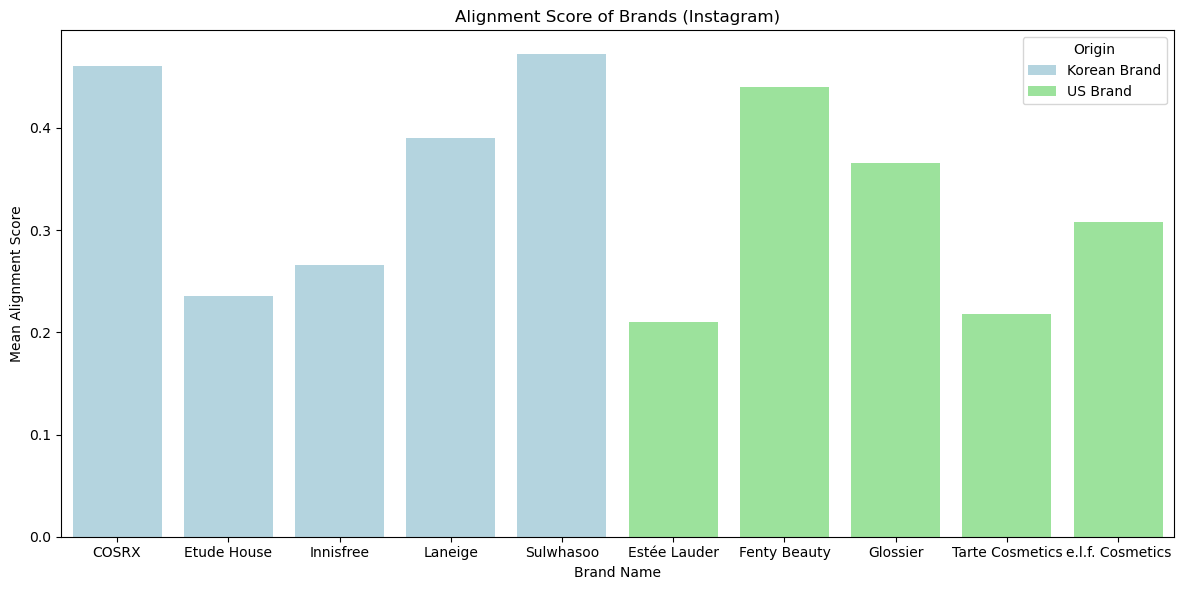

In [152]:
sorted_by_country = insight.sort_values(by=["country", "brand"])

plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_by_country, x="brand", y="mean_alignment", hue="country", palette={"Korean Brand": "lightblue", "US Brand": "lightgreen"})

plt.title("Alignment Score of Brands (Instagram)")
plt.xlabel("Brand Name")
plt.ylabel("Mean Alignment Score")
plt.legend(title="Origin")
plt.tight_layout()
plt.show()

## Main theme

In [154]:
# Extract top keywords from the brand's value and top keywords from the user's comment 

#function to clean the text 
def cleaning_the_text(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    return text

# function to extract keywords using FT-IDF 
def get_main_theme(text, top_n=7):
    if not text.strip():
        return None
    vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf_matrix = vectorizer.fit_transform([text])
    get_scores = tfidf_matrix.toarray().flatten() #convert text into TF-IDF-weighted vector 
    words = vectorizer.get_feature_names_out() # get a list of main theme 
    top_indices = get_scores.argsort()[::-1][:top_n]
    top_keywords = [words[keyword] for keyword in top_indices]
    return ", ".join(top_keywords)

#building a dataframe of main themes for each 
theme_df = []

for brand, group in sample_df.groupby("brand"):
    brand_mission = " ".join(group["brand_mission"].map(cleaning_the_text).unique())
    customer_comment = " ".join(group["cleaned_text"].map(cleaning_the_text))
    main_theme_brand = get_main_theme(brand_mission)
    main_theme_comment = get_main_theme(customer_comment)
    theme_df.append({
        "brand": brand,
        "brand_mission_main_theme": main_theme_brand,
        "user_comment_main_theme": main_theme_comment})

main_theme_df = pd.DataFrame(theme_df)

main_theme_df

,brand,brand_mission_main_theme,user_comment_main_theme
0,COSRX,"skin, cosmetics, beauty, customers, cosrx, want, founded","skin, cosrx, snail, cream, mention, redacted, acid"
1,Estée Lauder,"force, world, women, beauty, believed, caring, championing","lauder, est, skin, beauty, day, redacted, night"
2,Etude House,"make, pink, princess, like, color, women, fantasy","house, etude, tint, skin, cream, products, delhi"
3,Fenty Beauty,"fenty, hair, makeup, skin, styles, new, repair","beauty, fenty, makeup, lip, skin, foundation, shade"
4,Glossier,"makeup, beauty, skin, built, products, real, believe","glossier, makeup, hair, beauty, pink, mention, redacted"
5,Innisfree,"nature, healthy, beauty, island, innisfree, green, benefits","skin, innisfree, tea, green, mention, redacted, serum"
6,Laneige,"skin, create, visible, ingredients, better, bouncy, caring","skin, laneige, mask, lip, sleeping, cream, water"
7,Sulwhasoo,"skin, sulwhasoo, create, potential, activating, addressing, heritage","sulwhasoo, skin, serum, care, activating, ginseng, cream"
8,Tarte Cosmetics,"tarte, ingredients, believe, vegan, blend, boundaries, breaking","cosmetics, tarte, commission, products, beauty, affiliate, makeup"
9,e.l.f. Cosmetics,"good, look, vegan, animal, bad, eye, face","makeup, cosmetics, products, elf, beauty, blush, lip"


## LDA Modeling 

In [202]:
lemmatizer = WordNetLemmatizer()
stopword_set = set(nltk_stopwords.words('english')).union(custom_stopwords)

def preprocess(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return [lemmatizer.lemmatize(word) for word in tokens if word not in stopword_set and len(word) > 2]

all_brands = []

brand_list = sample_df["brand"].unique().tolist()

for brand in brand_list:
    brand_df = sample_df[sample_df["brand"] == brand]
    texts = brand_df["cleaned_text"].apply(preprocess).tolist()
    dictionary = Dictionary(texts)  
    corpus = [dictionary.doc2bow(text) for text in texts]  
    lda = LdaModel(corpus, num_topics=3, id2word=dictionary, passes=10)  
    vis_data = gensimvis.prepare(lda, corpus, dictionary)
    pyLDAvis.save_html(vis_data, f"../output/lda/lda_{brand.lower().replace(' ', '_')}.html")
    
    # Get the top words as topic lavel 
    topic_terms = lda.show_topics(num_topics=5, num_words=10, formatted=False)
    topic_label_map = {
        topic_id: " ".join([word for word, _ in words])  
        for topic_id, words in topic_terms
    }
    
    labeled_topics = []
    for doc_bow in corpus:
        topic_probs = lda.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic_id = max(topic_probs, key=lambda x: x[1])[0]
        raw_label = topic_label_map[dominant_topic_id]
        
        phrase = ", ".join(raw_label.split())
        sentence = f"People are talking about {brand}'s products with a focus on {phrase}, which may relate to skincare concerns or product features."
        labeled_topics.append(sentence)


    brand_df["topic_label"] = labeled_topics
    brand_df["topic_label"] = labeled_topics
    all_brands.append(brand_df)


all_brands_df = pd.concat(all_brands)
# all_brands_df.head()

/var/folders/rg/04c1t0sd7zdc_6sl31l_r9km0000gn/T/ipykernel_86038/3129739353.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_df["topic_label"] = labeled_topics
/var/folders/rg/04c1t0sd7zdc_6sl31l_r9km0000gn/T/ipykernel_86038/3129739353.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  brand_df["topic_label"] = labeled_topics
/var/folders/rg/04c1t0sd7zdc_6sl31l_r9km0000gn/T/ipykernel_86038/3129739353.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [181]:
brand_value.head()

,brand,slogan,brand_mission,brand_mission_theme
0,Estée Lauder,Beauty is an attitude,"A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.","influence force, force nature, force influence, nature force, lauder force, beautiful forces, force, force good, force change, force believed"
1,Fenty Beauty,Beauty for all,"FENTY BEAUTY: This is where Rihanna started it all, for all. More than just makeup, it’s a mission with a vision, serving foundation that put every tone on the map. Launching color that created new ways of being and seeing with loaded pigments and freestyle formulas. FENTY SKIN: Great skin makes great makeup. Start your base with Fenty Skin—smart, high-performance skincare with a clear mission: treat, smooth and tighten the look of pores, day and night, under makeup and over time. Never complicated, always clinical. FENTY HAIR: The radically transformative power of hair? Rihanna owns that. But serving looks and switchin’ styles can take its toll. Enter Fenty Hair: a new era of repair. It’s a line that infuses repair into every step for styles that won’t stop. Your hair on Fenty? It’s stronger by the style.","fenty hair, fenty beauty, hair fenty, fenty skin, hair rihanna, beauty rihanna, fenty, makeup, night makeup, makeup start"
2,e.l.f. Cosmetics,be extra withoutpaying extra,"e.l.f. is for every eye, lip and face. Your originality is our inspiration. From full-on maximalists to fresh-faced\nminimalists, we have a product for everyone—and every look in between. Look good and feel good—all our\nformulas are 100% vegan, no animal testing and made without the nasty bad-for-you stuff. Totally guilt-free.","vegan, 100 vegan, vegan animal, face originality, faced minimalists, guilt free, minimalists, minimalists product, lip face, eye lip"
3,Tarte Cosmetics,"Be green, be smart, be tarte.","About Tarte™\nAt tarte™, we believe in breaking down beauty\nboundaries, shattering stereotypes & being kind.\nWe believe in high-performance AND natural. All tarte products are formulated with a blend of naturally-derived & other ingredients designed to perform.\n• fruit & plant extracts from Mother Nature • clinically-proven ingredients\n• vegan-friendly options • consumer tested results","tarte products, natural tarte, tarte tarte, tarte, tarte believe, ingredients vegan, vegan friendly, vegan, products formulated, proven ingredients"
4,Glossier,You Look Good,"Before we launched Glossier in 2014, we started as Into The Gloss. A beauty website and community devoted to sharing real information with real people, about really amazing products. It’s where we realized that beauty shouldn’t be built in a boardroom—it should be built by you. This ethos gave birth to our philosophy: Skin First. Makeup Second™. We prioritize skincare because we believe that healthy skin is the best foundation. We believe in thoughtful design and cultivating conversations. It’s at the core of everything we do—the starting point of all our makeup, skincare, bodycare, and fragrance products. At Glossier, beauty is about celebrating freedom of expression, individuality , and having fun. Our Skin First. Makeup Second™ approach ensures that every product supports your skin’s health, allowing your makeup to enhance rather than mask your natural beauty.","glossier beauty, gloss beauty, makeup skincare, products glossier, makeup second, glossier, skin makeup, prioritize skincare, glossier 2014, launched glossier"


In [203]:
all_brands_df = all_brands_df.drop(columns=["brand_mission"], errors="ignore")
all_brands_df = all_brands_df.merge(
    brand_value[["brand", "brand_mission"]],
    on="brand",
    how="left"
)
def compute_similarity(row):
    topic_embed = model.encode(row["topic_label"], convert_to_tensor=True)
    mission_embed = model.encode(row["brand_mission"], convert_to_tensor=True)
    return float(util.cos_sim(topic_embed, mission_embed).item())

summary = (
    all_brands_df.groupby(["brand", "topic_label", "brand_mission"])["alignment_score"]
    .mean()
    .reset_index()
)

summary["similarity_score"] = summary.apply(compute_similarity, axis=1)

# summary.to_csv('../output/topic_user_score.csv')

In [204]:
summary

,brand,topic_label,brand_mission,alignment_score,similarity_score
0,COSRX,"People are talking about COSRX's products with a focus on product, skin, mention, redacted, cream, cosrx, eye, toner, also, skincare, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.434999,0.743096
1,COSRX,"People are talking about COSRX's products with a focus on skin, cosrx, skincare, product, acne, acid, toner, bha, help, use, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.478262,0.681894
2,COSRX,"People are talking about COSRX's products with a focus on skin, cosrx, snail, serum, acid, redacted, mention, cream, mucin, available, which may relate to skincare concerns or product features.","COSRX believes that cosmetics should give more than just outward beauty. We are devoted to enabling individuals to find solutions according to their personal skin conditions. We strive to help our customers to gain self-confidence, and ultimately to find their own unique beauty inside.\nSince 2002 and finally, “Cosmetics + RX(Prescription) = COSRX” was founded in 2013. With skin-friendly ingredients that alleviate irritated skin, we want to provide a better tomorrow for our customers.",0.460280,0.708925
3,Estée Lauder,"People are talking about Estée Lauder's products with a focus on est, lauder, beauty, lip, brand, company, global, packaging, year, paper, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.218416,0.275996
4,Estée Lauder,"People are talking about Estée Lauder's products with a focus on lauder, est, day, wear, skin, shade, available, beauty, makeup, foundation, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.207578,0.310390
5,Estée Lauder,"People are talking about Estée Lauder's products with a focus on lauder, est, skin, night, mention, redacted, serum, repair, advanced, woman, which may relate to skincare concerns or product features.","A force is an influence. A force of nature. A force for change.\nOur founder, Mrs. Estée Lauder, was a force who believed in the power of women.\nBeautiful Forces represents our mission as a force for good: the beauty of caring for\nthe world we live in and championing those who will help shape its future.",0.204745,0.290858
6,Etude House,"People are talking about Etude House's products with a focus on house, cream, etude, cover, skin, product, perfect, missha, tint, acne, which may relate t

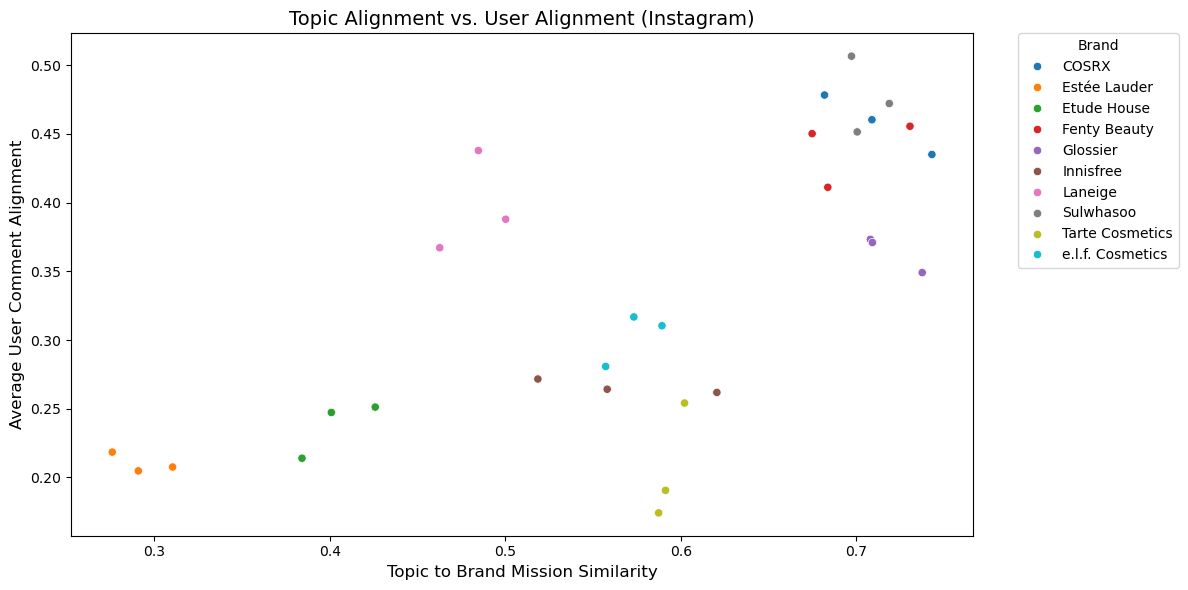

In [215]:
plt.figure(figsize=(12, 6)) 
sns.scatterplot(data=summary, x="similarity_score", y="alignment_score", hue="brand",)
plt.title("Topic Alignment vs. User Alignment (Instagram)", fontsize=14)
plt.xlabel("Topic to Brand Mission Similarity", fontsize=12)
plt.ylabel("Average User Comment Alignment", fontsize=12)
plt.legend(title="Brand", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)

plt.tight_layout()
plt.show()

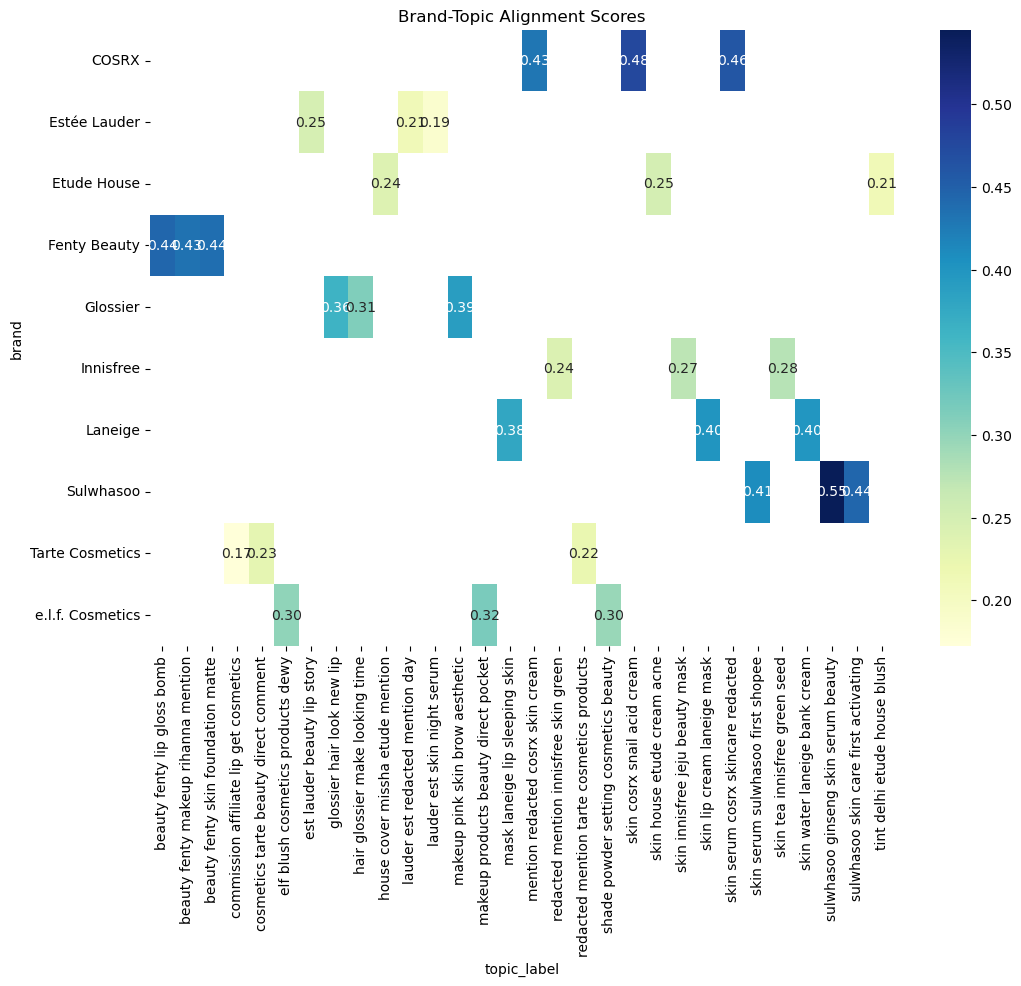

In [165]:
pivot_table =summary.pivot_table(index="brand", columns="topic_label", values="alignment_score")
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Brand-Topic Alignment Scores")
plt.show()